In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from statsmodels.discrete.discrete_model import Logit
from scipy.optimize import minimize
from statsmodels.tools.tools import add_constant

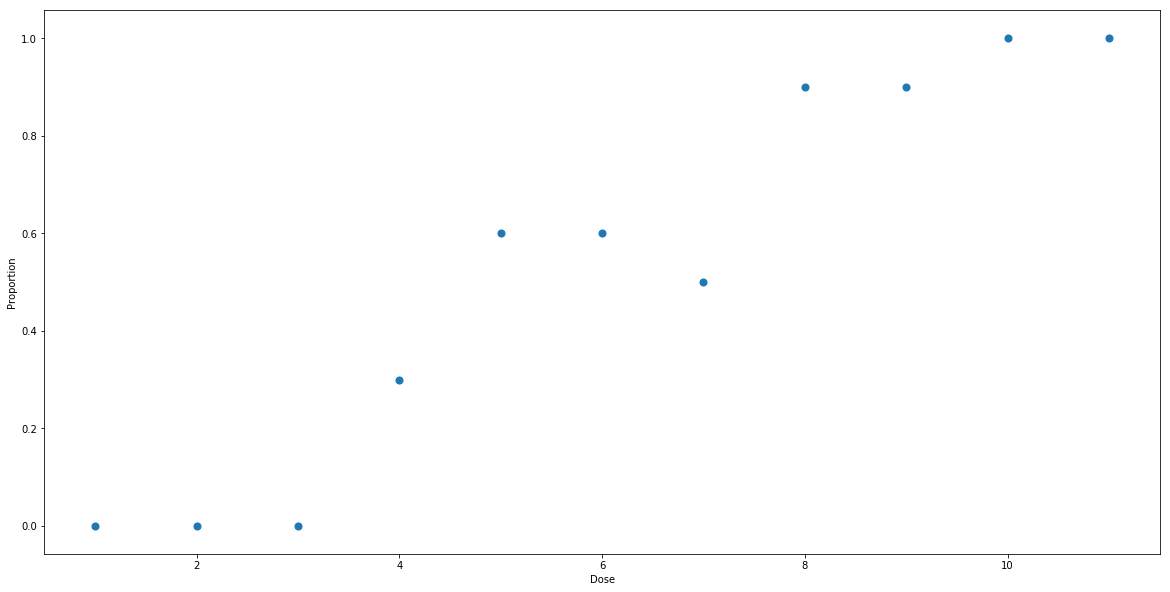

In [2]:
# Import and plot data
dr_df = pd.read_csv('doseresponse.csv')
dr_df['Dose'] = dr_df['Dose'] + 1
dr_df.plot(x='Dose', y='Proportion', kind='scatter', figsize=(20,10), s=50)

In [3]:
# Compute logit of proportions
preproc_prop = np.minimum(np.maximum(dr_df['Proportion'], 0.01), 0.99)
#preproc_prop = dr_df['Proportion']
lamb = np.log(preproc_prop / (1 - preproc_prop)) # lambda i's
# Fit OLS by MLE
model = OLS(lamb, add_constant(np.array(dr_df['Dose']))).fit()

In [4]:
model.summary()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Proportion   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     111.1
Date:                Fri, 11 Oct 2019   Prob (F-statistic):           2.31e-06
Time:                        09:45:59   Log-Likelihood:                -14.327
No. Observations:                  11   AIC:                             32.65
Df Residuals:                       9   BIC:                             33.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.9546      0.636     -9.358      0.000      -7.394      -4.515
x1             0.9888      0.094     10.540      0.000       0.777       1.201
==============================================================================
Omnibus:                        0.345   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.842   Jarque-Bera (JB):                0.455
Skew:                          -0.122   Prob(JB):                        0.797
Kurtosis:                       2.034   Cond. No.                         14.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
beta_0, beta_1 = model.params.values[0], model.params.values[1]

In [6]:
# Use coefficients to compute pi_hat
p_hat = (1 + np.exp((-1) * (beta_0 + beta_1 * np.linspace(1,11,200)))) ** (-1)

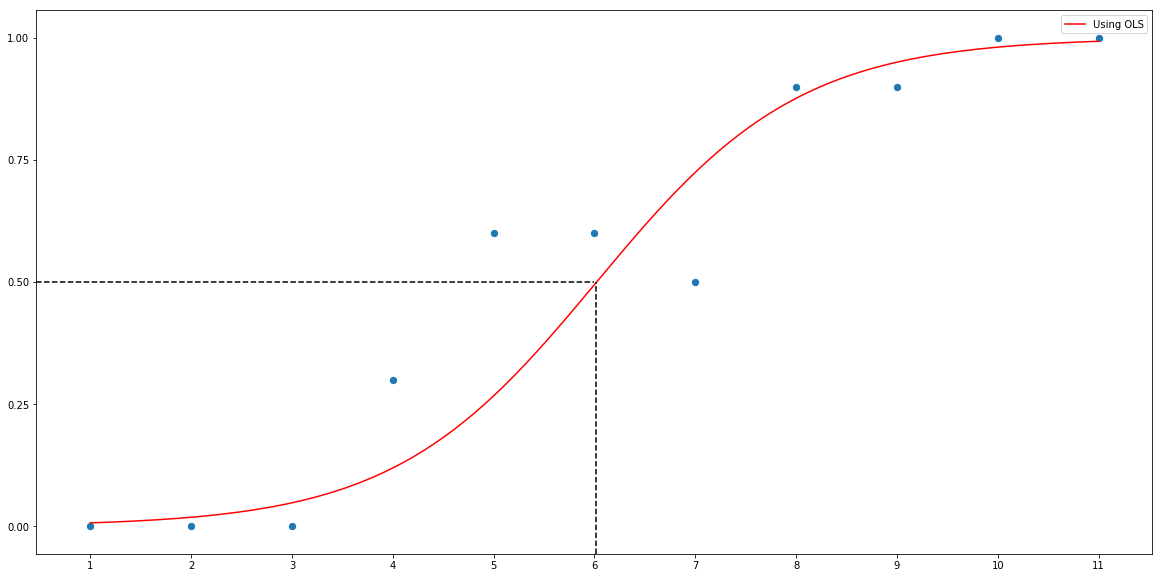

In [7]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.set_xticks(np.linspace(1,11,11))
ax.set_yticks(np.linspace(0,1,5))
ax.scatter(dr_df['Dose'], dr_df['Proportion'], s=40)
ax.plot(np.linspace(1,11,200), p_hat, '-r')
ax.axhline(0.5, 0, .5, linestyle='--', color='k')
ax.axvline(6.02, 0, .5, linestyle='--', color='k')
ax.legend(['Using OLS'])

In [8]:
def deviance(true_prop, dose, beta_0, beta_1):
    
    est_prop = (1 + np.exp((-1) * (beta_0 + beta_1 * dose))) ** (-1)
    dev = np.sum(np.log((true_prop * np.log(1 + true_prop/est_prop) + 
                  (1 - true_prop) * np.log(1 + (1- true_prop) / (1 - est_prop)))))
    
    return dev

In [9]:
beta_0, beta_1 = minimize(lambda theta: deviance(dr_df['Proportion'].values, dr_df['Dose'].values, 
                                theta[0], theta[1]), (-5,.7), method='L-BFGS-B')['x']

In [10]:
p_hat_dev = (1 + np.exp((-1) * (beta_0 + beta_1 * np.linspace(1,11,200)))) ** (-1)

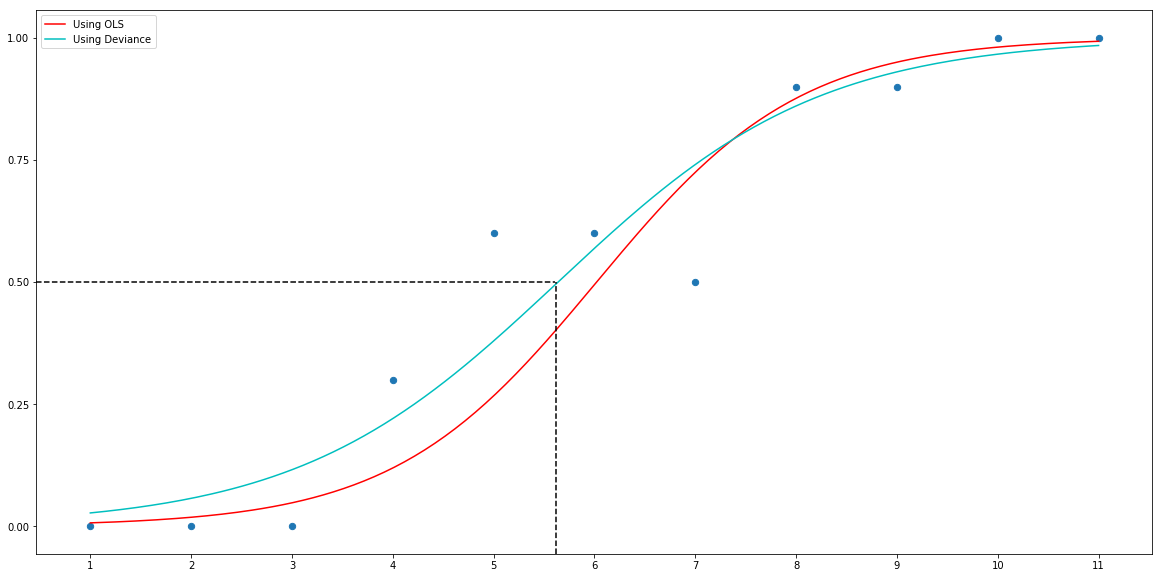

In [11]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.set_xticks(np.linspace(1,11,11))
ax.set_yticks(np.linspace(0,1,5))
ax.scatter(dr_df['Dose'], dr_df['Proportion'], s=40)
ax.plot(np.linspace(1,11,200), p_hat, '-r')
ax.plot(np.linspace(1,11,200), p_hat_dev, '-c')
ax.axhline(0.5, 0, .465, linestyle='--', color='k')
ax.axvline(5.62, 0, .5, linestyle='--', color='k')
ax.legend(['Using OLS', 'Using Deviance'])

In [12]:
logit_mod = Logit(dr_df['Proportion'], add_constant(np.array(dr_df['Dose']))).fit()
logit_mod.summary()

Optimization terminated successfully.
         Current function value: 0.279901
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Proportion   No. Observations:                   11
Model:                          Logit   Df Residuals:                        9
Method:                           MLE   Df Model:                            1
Date:                Fri, 11 Oct 2019   Pseudo R-squ.:                  0.5947
Time:                        09:49:47   Log-Likelihood:                -3.0789
converged:                       True   LL-Null:                       -7.5970
Covariance Type:            nonrobust   LLR p-value:                  0.002647
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7031      2.809     -1.674      0.094     -10.209       0.803
x1             0.8260      0.464      1.781      0.075      -0.083       1.735
==============================================================================
"""

In [13]:
logit_preds = logit_mod.predict(add_constant(np.linspace(1,11,200)))

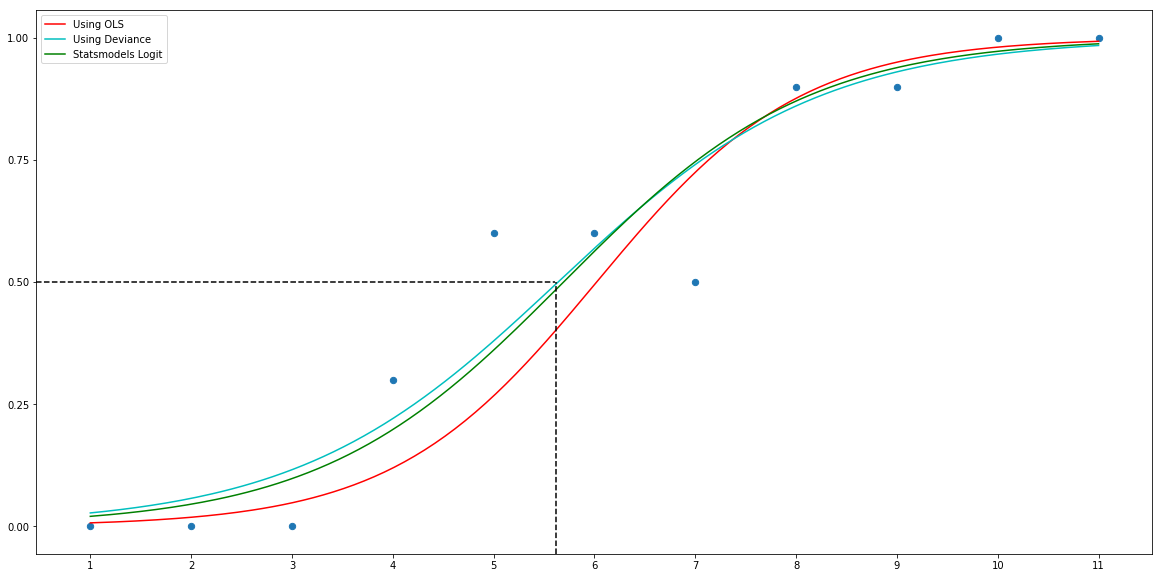

In [14]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.set_xticks(np.linspace(1,11,11))
ax.set_yticks(np.linspace(0,1,5))
ax.scatter(dr_df['Dose'], dr_df['Proportion'], s=40)
ax.plot(np.linspace(1,11,200), p_hat, '-r')
ax.plot(np.linspace(1,11,200), p_hat_dev, '-c')
ax.plot(np.linspace(1,11,200), logit_preds, '-g')
ax.axhline(0.5, 0, .465, linestyle='--', color='k')
ax.axvline(5.62, 0, .5, linestyle='--', color='k')
ax.legend(['Using OLS', 'Using Deviance', 'Statsmodels Logit'])

In [15]:
prop_est = logit_mod.predict()
# estimate confidence interval for predicted probabilities
cov = model.cov_params() # Could have gotten covariance matrix of our parameters using Fisher Inf. However, let's save some work.
gradient = (prop_est * (1 - prop_est) * add_constant(np.linspace(1,11,11)).T).T # matrix of gradients for each observation
std_errors = np.array([np.sqrt(np.dot(np.dot(g, cov), g)) for g in gradient])

In [16]:
np.round(std_errors,3)

array([0.011, 0.021, 0.036, 0.056, 0.072, 0.073, 0.059, 0.04 , 0.023,
       0.013, 0.007])

In [17]:
p_hat_grid_dev = (1 + np.exp((-1) * (beta_0 + beta_1 * np.linspace(1,11,11)))) ** (-1)
np.round(np.sqrt(p_hat_grid_dev * (1 - p_hat_grid_dev) / 10),3)

array([0.052, 0.073, 0.101, 0.131, 0.153, 0.157, 0.139, 0.11 , 0.081,
       0.057, 0.039])